In [1]:
using CairoMakie
using CSV
using ArchGDAL
using DataFrames
using MLJ
using Statistics

In [2]:
# Import geodatabase
gdb_path = "C:/Users/julio/Desktop/data/GDB_5PROV.gdb"
gdb = ArchGDAL.read(gdb_path) |>
x -> ArchGDAL.getlayer(x, 3)

df = DataFrame(gdb) |>
x -> select(x, Not([:Shape, :Id_micro, :Shape_Length, :Shape_Area]));

In [3]:
describe(df) |>
x -> sort(x, :nmissing, rev=true) |>
x -> first(x, 5)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,area_ha,1375.99,96.48,1115.64,6097.59,0,Float64
2,pas,290.467,0.0,144.703,3376.14,0,Float64
3,cul,104.078,0.0,9.46751,3626.62,0,Float64
4,bn,217.291,0.0,0.534724,4194.8,0,Float64
5,par,281.556,0.0,0.0,4515.92,0,Float64


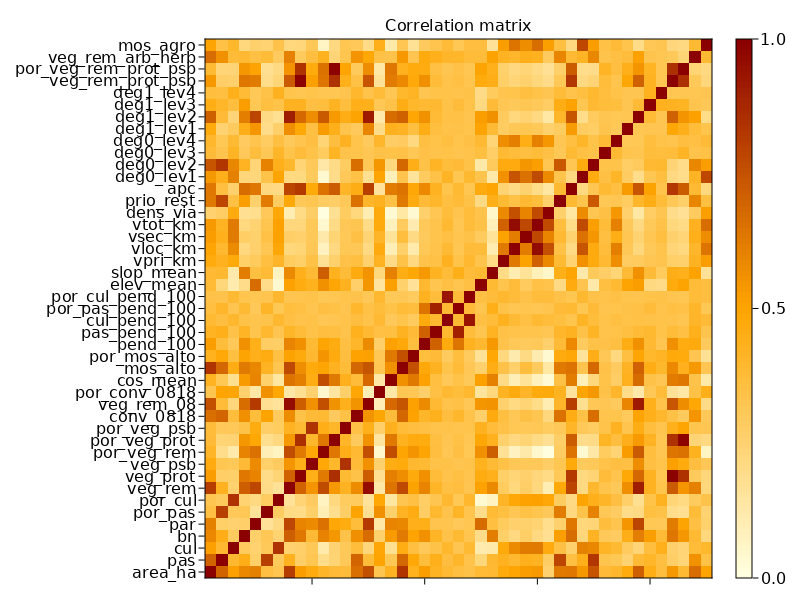

In [7]:
f = Figure()
yticks = (1:length(names(df)), names(df))
ax = Axis(f[1, 1], title="Correlation matrix", xticklabelsvisible=false, yticks=yticks)
heatmap!(cor(Matrix(df)), colormap=:heat)
Colorbar(f[1, 2], colormap=:heat)
f

In [8]:
# Get list of models
println([(m.name, m.package_name) for m in models(matching(df)) if m.is_pure_julia == true && m.is_supervised == false])

[("ABODDetector", "OutlierDetectionNeighbors"), ("AEDetector", "OutlierDetectionNetworks"), ("COFDetector", "OutlierDetectionNeighbors"), ("ContinuousEncoder", "MLJModels"), ("DNNDetector", "OutlierDetectionNeighbors"), ("FactorAnalysis", "MultivariateStats"), ("FeatureSelector", "MLJModels"), ("FillImputer", "MLJModels"), ("GMMClusterer", "BetaML"), ("ICA", "MultivariateStats"), ("KMeans", "BetaML"), ("KMeans", "Clustering"), ("KMeans", "ParallelKMeans"), ("KMedoids", "BetaML"), ("KMedoids", "Clustering"), ("KNNDetector", "OutlierDetectionNeighbors"), ("KernelPCA", "MultivariateStats"), ("LOFDetector", "OutlierDetectionNeighbors"), ("MissingImputator", "BetaML"), ("OneHotEncoder", "MLJModels"), ("PCA", "MultivariateStats"), ("PPCA", "MultivariateStats"), ("Standardizer", "MLJModels"), ("TSVDTransformer", "TSVD")]


In [9]:
# K-Means
model_kmeans = @load KMeans pkg=Clustering verbosity=0
pipe_kmeans = @pipeline Standardizer model_kmeans(k=4)
mach_kmeans = machine(pipe_kmeans, df) |> fit!;

┌ Info: Training Machine{Pipeline277,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{KMeans,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


In [10]:
rep_kmeans = report(mach_kmeans)

(k_means = (assignments = [1, 2, 1, 1, 1, 1, 2, 2, 1, 1  …  1, 3, 1, 1, 1, 1, 1, 3, 1, 1],
            cluster_labels = CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 2, 3, 4],),
 standardizer = (features_fit = [:por_veg_prot, :veg_psb, :deg1_lev3, :vloc_km, :veg_prot, :pas, :mos_agro, :deg1_lev1, :cos_mean, :vsec_km  …  :elev_mean, :dens_via, :deg0_lev1, :por_cul_pend_100, :deg1_lev2, :deg0_lev3, :pend_100, :por_veg_rem_prot_psb, :deg0_lev4, :deg0_lev2],),
 machines = Machine[Machine{Standardizer,…}, Machine{KMeans,…}],
 report_given_machine = OrderedCollections.LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{Standardizer,…} => (features_fit = [:por_veg_prot, :veg_psb, :deg1_lev3, :vloc_km, :veg_prot, :pas, :mos_agro, :deg1_lev1, :cos_mean, :vsec_km  …  :elev_mean, :dens_via, :deg0_lev1, :por_cul_pend_100, :deg1_lev2, :deg0_lev3, :pend_100, :por_veg_rem_prot_psb, :deg0_lev4, :deg0_lev2],), Machine{KMeans,…} => (assignments = [1, 2, 1, 1, 1, 1, 2, 2, 1, 1  …  1, 3, 1, 1, 1

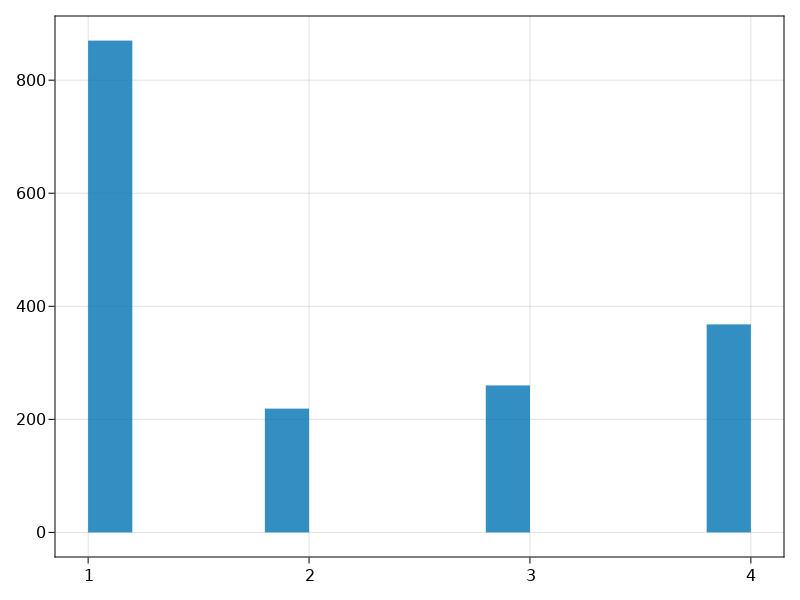

In [11]:
res_kmeans = collect(rep_kmeans.k_means[1])
hist(res_kmeans)

In [12]:
df[!, :clusters] = res_kmeans

1717-element Vector{Int64}:
 1
 2
 1
 1
 1
 1
 2
 2
 1
 1
 ⋮
 3
 1
 1
 1
 1
 1
 3
 1
 1

In [13]:
summary_df = df |> 
x -> groupby(x, :clusters) |>
x -> combine(x, names(x) .=> mean)


,clusters,area_ha_mean,pas_mean,cul_mean,bn_mean,par_mean,por_pas_mean,por_cul_mean
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,850.244,213.639,57.3763,87.6102,152.52,24.8081,7.55324
2,2,2568.76,961.473,131.674,484.748,229.647,39.1131,4.82165
3,3,1622.11,222.342,363.567,13.8453,47.8513,12.8199,22.2163
4,4,1735.22,120.908,14.7301,508.446,782.625,6.54955,0.687671


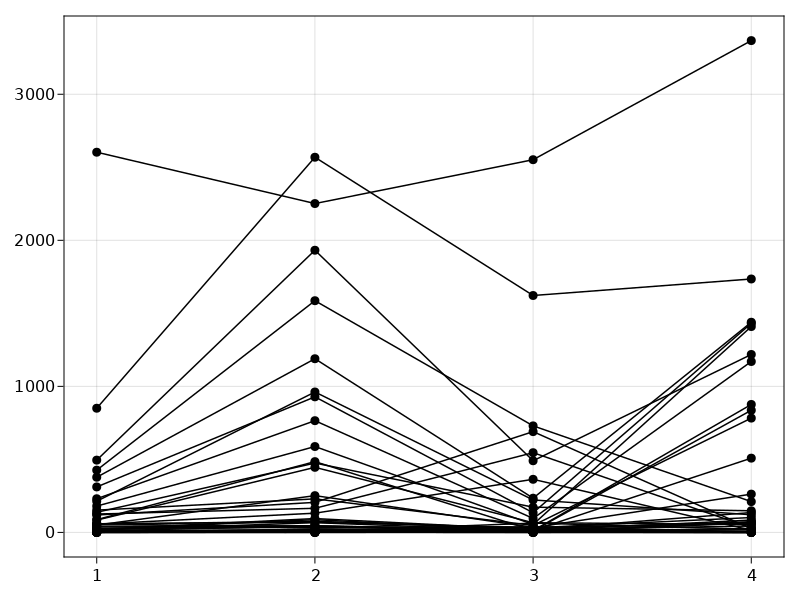

In [44]:
# nonsense figure
f = Figure()
Axis(f[1, 1])
function plot_lines(df)
    for col in names(df[!, 2:end])
        scatterlines!(df[!, 1], df[!, col])
    end
end
plot_lines(summary_df)
f

In [18]:
# Export results
CSV.write("C:/Users/julio/Desktop/data/clusters.csv", DataFrame(id=1:length(res_kmeans), clusters=res_kmeans))

"C:/Users/julio/Desktop/data/clusters.csv"